## Project 2 

### Name: Qiuiyng Li (Yvonne)  Student ID: 19042765

### Name: Tao Jiang (Tommy)  Student ID: 20004769

# M5 Forecasting - Uncertainty


## EDA

## Abstract
### With the development of the market economy and the globalization of the economy, enterprises are facing increasingly brutal market competition. If enterprises want to win the race and win customers, they must provide products to customers at the lowest cost in the fastest time. This makes accurate and timely product sales forecasts, and the resulting reliable decisions become a modern enterprise success. Sales forecasting can be regarded as a system, which is a process of information data conversion composed of the input, processing, and output of related information materials. For complex prediction objects, it is sometimes necessary to decompose it, predict the decomposed subsystem, and then predict the overall prediction target on this basis. In this analysis, we used a variety of methods to determine the most appropriate way for different types of situations that require prediction and uncertainty estimation.



### *Research Question*: 
>  ### 1) The tendency of average monthly sales

> ### 2) What kind of factors affect sales

> ### 3）Forecast sales for the next 28 days

## Summary 
### First of all, we raised questions about the stratified sales data provided by Wal-Mart and clarified the direction of analysis. Our analysis shows that overall sales are cyclical and slowly rising, while California sales are higher than other states. Among them, food products are hot sale products. Among them, food products are hot sale products. Then hierarchical sales dataset was merged, and the storage format was changed. Subsequently, a variety of methods were used to build different models, such as XGBoost, Ridge Regression, Random Forest, Lightgbm, KNN, etc., and different results were obtained. From the results, the best results can be obtained after running the KNN model, which got a score of 0.21131 by Kaggle.


* ## Load the data and analysis libraries
> ### Load libraries

In [ ]:
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time	
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline 
from pylab import rcParams
rcParams['figure.dpi'] = 120
rcParams['savefig.dpi'] = 120 
rcParams['font.size'] = 12

> ### Load the Kaggle dataset.

In [ ]:
data = pd.read_csv('../datasets/sales_train_validation.csv')
print(data.shape)
data.head(2)

(30490, 1919)


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
prices = pd.read_csv('../datasets/sell_prices.csv')
print(prices.shape)
prices.head(2)

(6841121, 4)


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58


In [ ]:
submission = pd.read_csv('../datasets/sample_submission.csv')
print(submission.shape)
submission.head(2)

(771120, 29)


,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,Total_X_0.005_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CA_X_0.005_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
cal = pd.read_csv('../datasets/calendar.csv')
print(cal.shape)
cal.head(2)

(1969, 14)


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0


> ### We got four massive datasets from Kaggle. For the EDA part, we analyze the 'sales_train_validation' so far. We will then merge at the stage of the Data Processing. 

> ### We can get the daily sales volume of different commodities. The following table shows the sales volume in the past seven days.

In [ ]:
series_cols = data.columns[data.columns.str.contains("d_")].values 

data_days = data[series_cols]
data_days.iloc[:,1906:].head()

,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,1,1,1,3,0,1,1
1,0,0,1,0,0,0,0
2,1,1,1,0,1,1,1
3,4,1,0,1,3,7,2
4,0,1,1,2,2,2,4


> ### The following is the cumulative number of all products sold in the last five days.

In [ ]:
data[series_cols].sum().tail() 

d_1909    35343
d_1910    35033
d_1911    40517
d_1912    48962
d_1913    49795
dtype: int64

> ### The chart below shows that the daily sales volume is in a cyclical change and has a small increase slowed.

Text(0.5, 1.0, 'Sales Distribution')

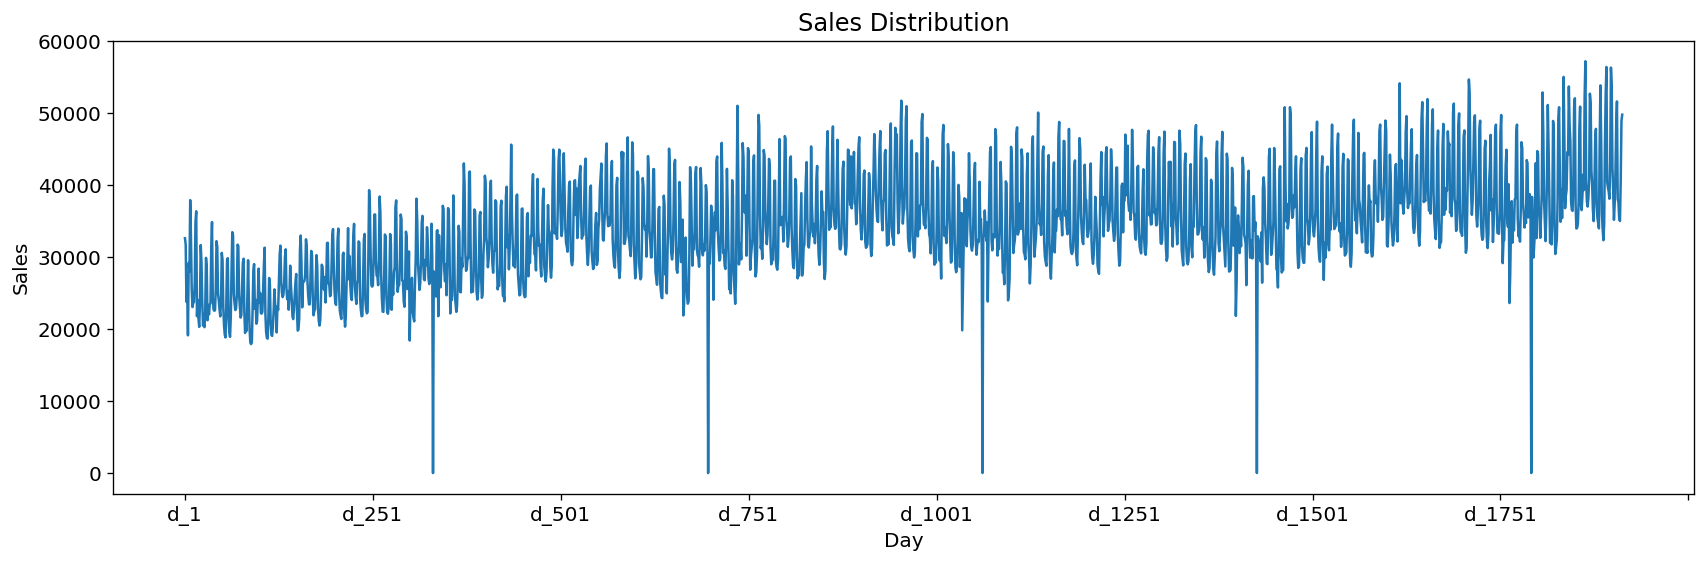

In [ ]:
rcParams['figure.figsize'] = (17,5)
data_days_sales = data_days.sum() 
data_days_sales.plot()
plt.xlabel('Day') 
plt.ylabel('Sales') 
plt.title("Sales Distribution")

> ### The distribution density chart below further confirms that sales are approximately Gaussian.

Text(0.5, 1.0, 'Daily Sales')

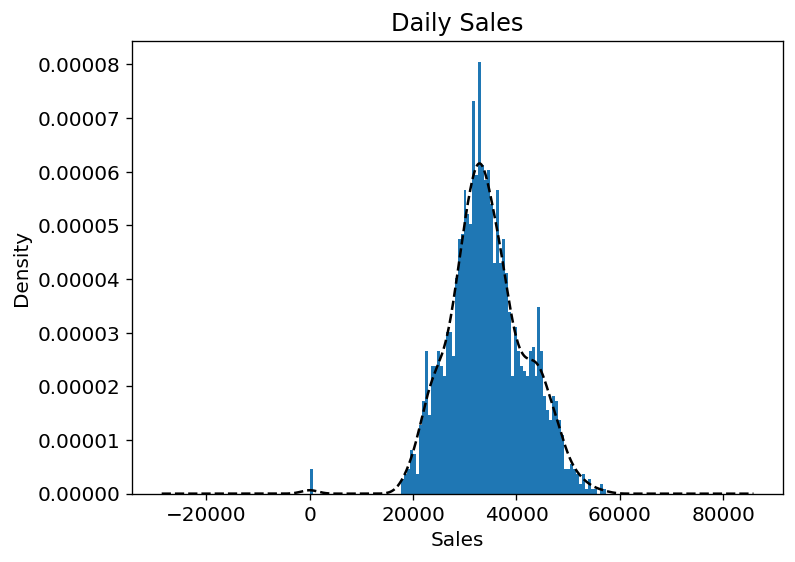

In [ ]:
rcParams['figure.figsize'] = (7,5)
data_days_sales.hist(bins = 100,histtype = 'bar',normed =True)
data_days_sales.plot(kind='kde',style='k--')
plt.xlabel('Sales') 
plt.title("Daily Sales")


>### The M5 competitor's guide mentions that there were SNAP purchases on the inspection date, which resulted in relatively low sales. We list them below.

In [ ]:
lowest_sale =  data[series_cols].sum()
lowest_sale = lowest_sale[lowest_sale<1000]
lowest_sale

d_331     13
d_697     11
d_1062    20
d_1427    20
d_1792    14
dtype: int64

>### We could found the next examined date is 2148, and it is not included in the 28 days we will predict. We can ignore this factor in the prediction model.


In [ ]:
period = []
days = []
for i,val in enumerate(lowest_sale.index):
    days.append(int(val[2:]))
    if i+1 < len(lowest_sale.index):
        period.append( int(lowest_sale.index[i+1][2:])-int(lowest_sale.index[i][2:]))
    
print(period) 
end_day = lowest_sale.index[-1].split("_")[1]
next_period= int(end_day) + period[0]
next_period  

[366, 365, 365, 365]


2158

>### Figure the daily sales of various states.

In [ ]:
data.groupby("state_id")[series_cols].sum()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
state_id,,,,,,,,,,,,,,,,,,,,,
CA,14195,13805,10108,11047,9925,11322,12251,16610,14696,11822,...,16255,20564,23032,17052,15784,15148,14488,17095,21834,23187
TX,9438,9630,6778,7381,5912,9006,6226,9440,9376,7319,...,10800,12460,13709,9868,10922,9600,9602,10615,12266,12282
WI,8998,8314,6897,6984,3309,8883,9533,11882,8664,6431,...,14734,15338,14899,11139,10864,10595,10943,12807,14862,14326


>### The graph shows that the highest of daily sales in CA. TX and WI regular sales are almost the same.

Text(0.5, 1.0, 'States Distribution')

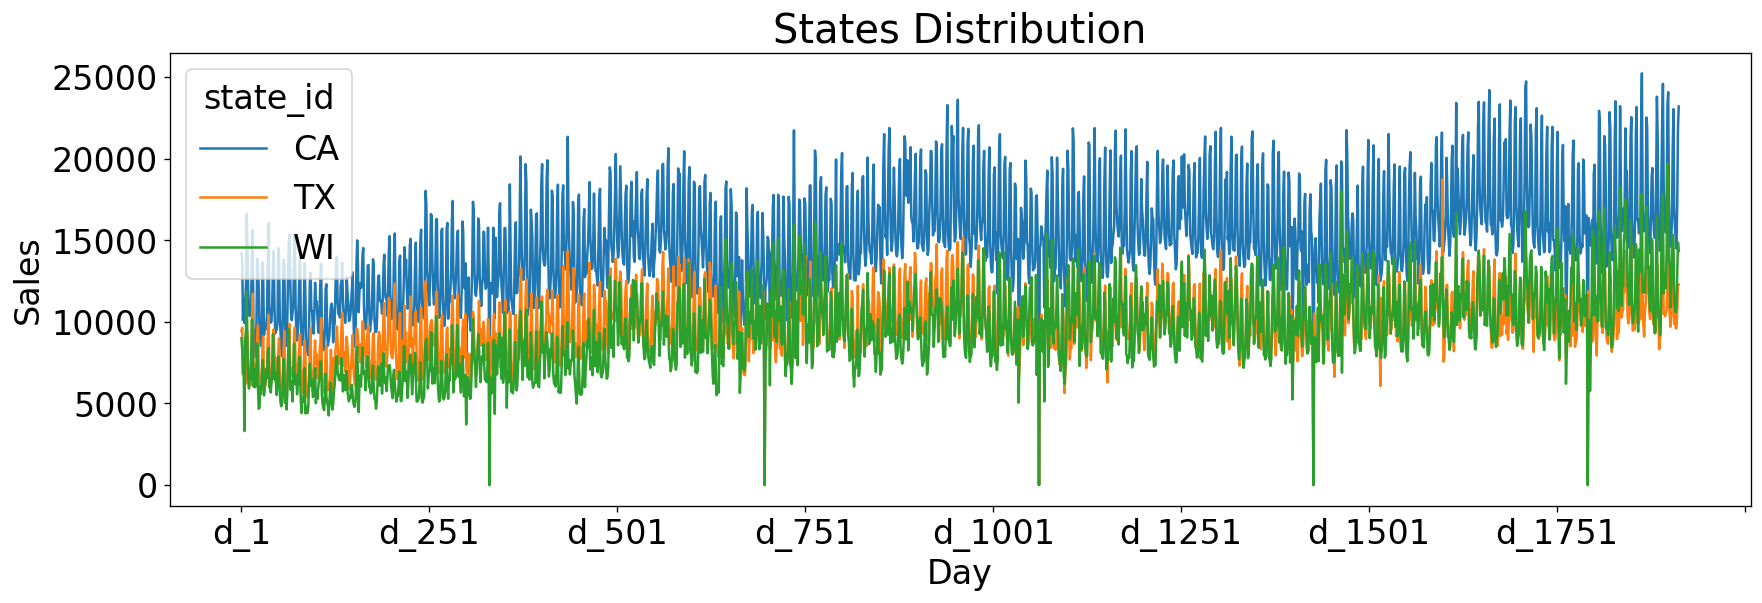

In [ ]:
data.groupby("state_id")[series_cols].sum().transpose().plot()
plt.xlabel('Days') 
plt.ylabel('Sales') 
plt.title("States Distribution")

> ### The illustration below shows the sales of different stores in California. Even though California has the highest daily deals, the situation in each store is different.

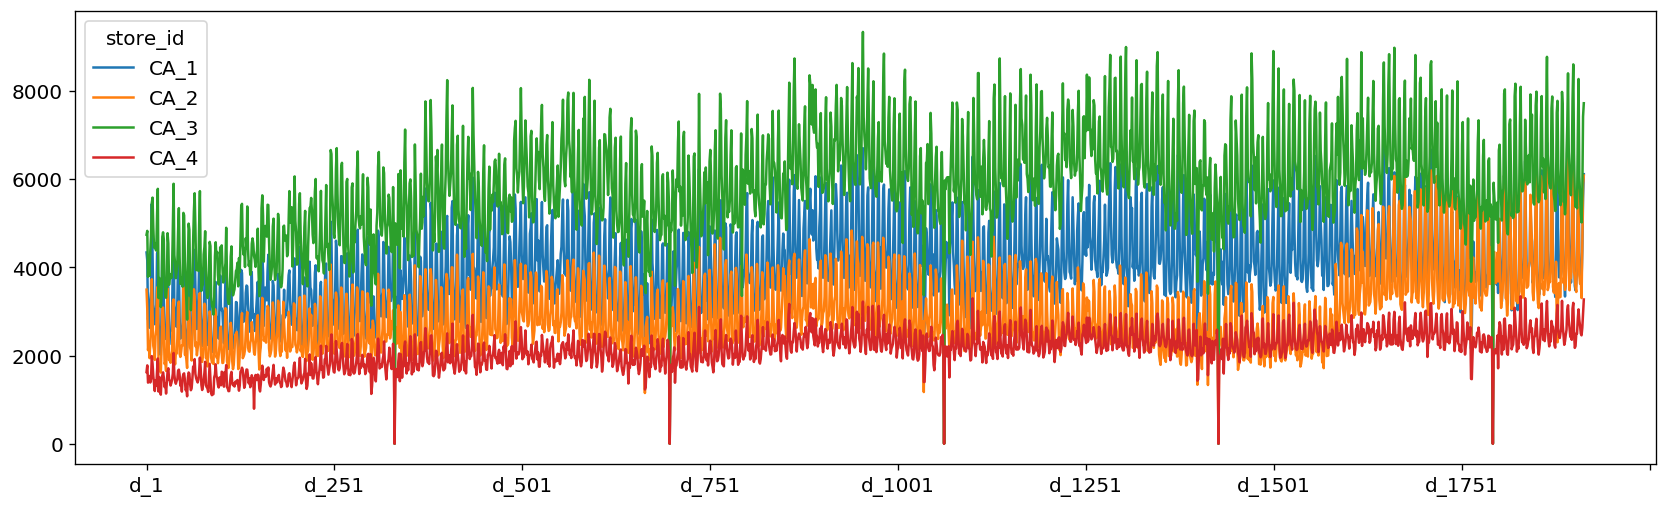

In [ ]:
CA = data[data['state_id'] =='CA']
TX = data[data['state_id'] =='TX']
WI = data[data['state_id'] =='WI']

rcParams['figure.figsize'] = (17,5)
CA.groupby("store_id")[series_cols].sum().transpose().plot()


> ### The graph below shows that the sales of food categories are much higher than in other types.

Text(0.5, 1.0, 'Category Distribution')

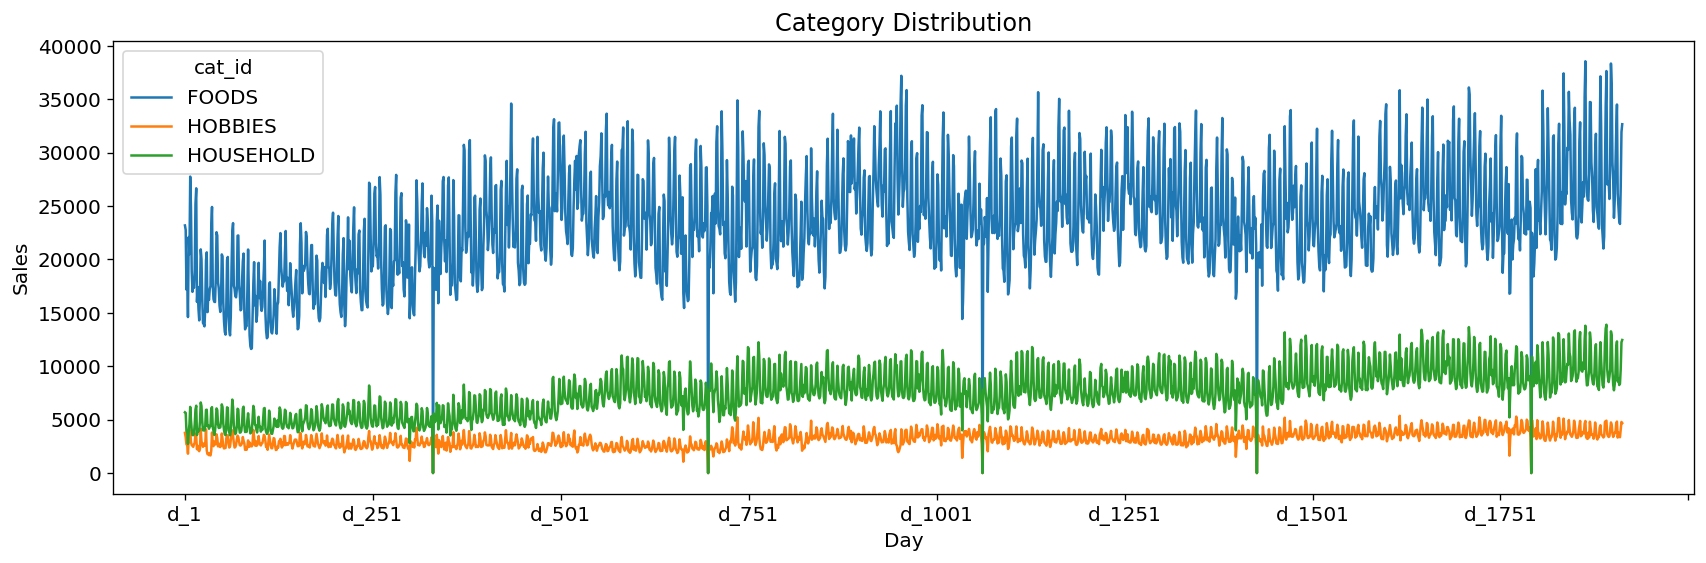

In [ ]:
data.groupby("cat_id")[series_cols].sum().transpose().plot()
plt.xlabel('Days') 
plt.ylabel('Sales') 
plt.title("Category Distribution")

> ### There are daily sales of distributing by the department. And foods_3 is the hot sale on all products. Moreover, the daily sales volume of the company has visible periodic changes.

Text(0.5, 1.0, 'Department Distribution')

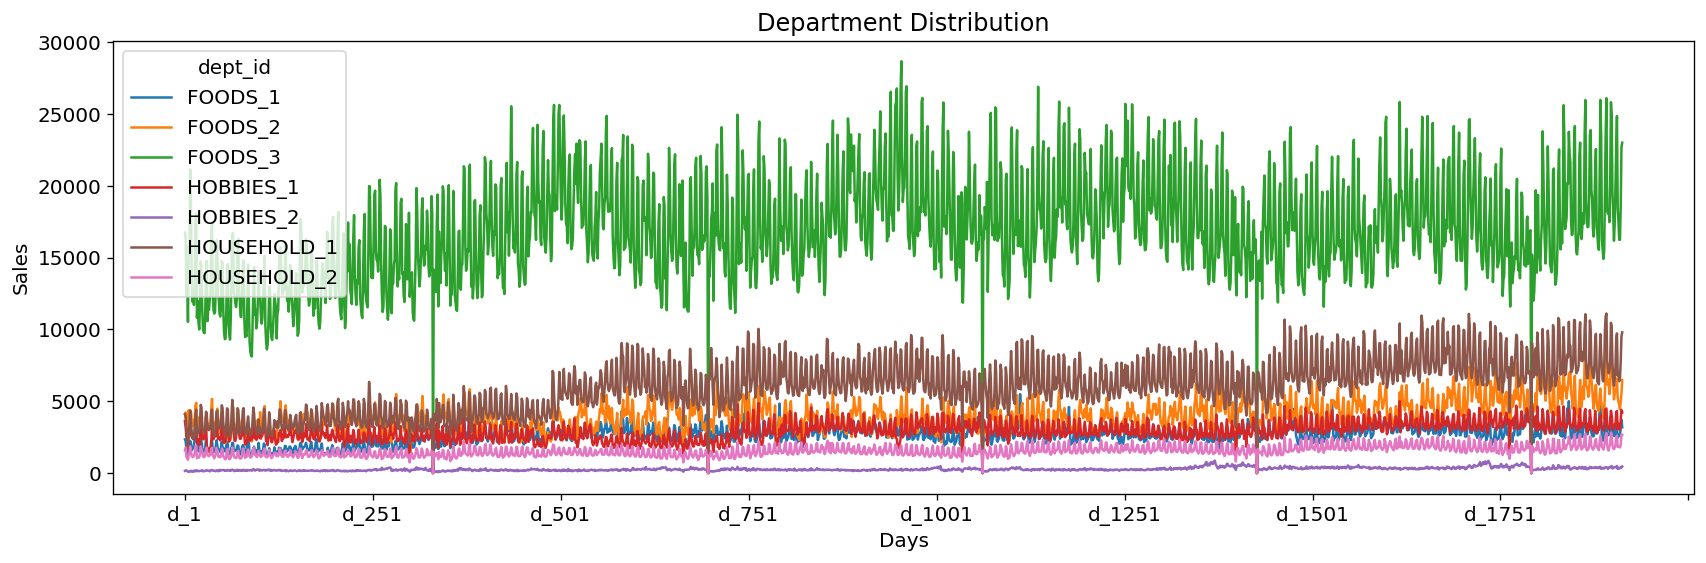

In [ ]:
data.groupby("dept_id")[series_cols].sum().transpose().plot()
plt.xlabel('Days') 
plt.ylabel('Sales') 
plt.title("Department Distribution")

### Through the above analysis, we can know the general trend of daily product sales. To make regular forecast sales for the next 28 days and to make uncertainty estimates, we need to end more machine learning methods to build models for accurate prediction analysis.